In [2]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy

In [3]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [4]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_00.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_01.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_02.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_03.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_04.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_05.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_06.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_07.wav'), PosixPath(

In [5]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


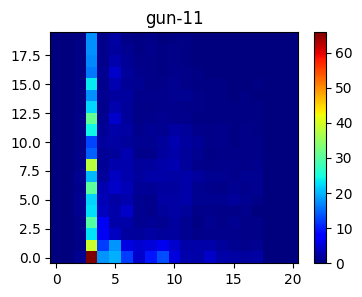

In [6]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

idx = 10
myds.display(["gun", idx])

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [7]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7

featveclen = len(myds["fire", 0])  # number of items in a feature vector
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
nlearn = round(naudio * train_pct)  # number of sounds among naudio for training
data_aug_factor = 1

class_ids_aug = np.repeat(classnames, naudio * data_aug_factor)
print

X = np.zeros((data_aug_factor * nclass * naudio, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            if classname == "gun" and idx == naudio - 1:
                continue
            featvec = myds[classname, idx]
            X[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)



X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")

print(
    "Remember the convention shown for the toy example, the feature vectors are arranged on the rows."
)

Shape of the feature matrix : (160, 400)
Number of labels : 160
Remember the convention shown for the toy example, the feature vectors are arranged on the rows.


You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

In [8]:
n = 14  # Number of principal components kept
model_pca = PCA(n_components=n, whiten=True)
# [4] Model training and selection.
K = 8
model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")

model_rf = RandomForestClassifier(n_estimators=100, 
                             max_depth=2,
                             min_impurity_decrease=0.01
                             ,min_samples_leaf=2,
                             min_samples_split=3,
                             random_state=0)
model_lda = LDA(
    solver="svd",
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
) 

As for the toy example, we keep the ``accuracy`` and ``confusion matrix`` as performance metrics. <br>

Note that here we are not especially interested in a model selection hence we only split the dataset in training and testing parts but we don't split the training set in learning/validation parts. The models are trained on the entire training set.

Shape of the training matrix : (112, 400)
Number of training labels : 112
Accuracy of the classifier with fixed train/validation sets : 83.3%


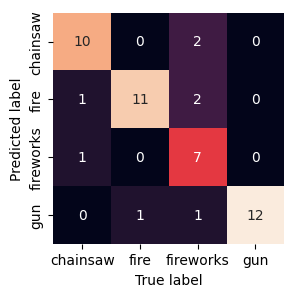

Shape of the training matrix : (112, 400)
Number of training labels : 112
Accuracy of the classifier with fixed train/validation sets : 60.4%


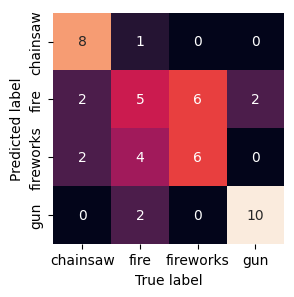

Shape of the training matrix : (112, 400)
Number of training labels : 112
Accuracy of the classifier with fixed train/validation sets : 66.7%


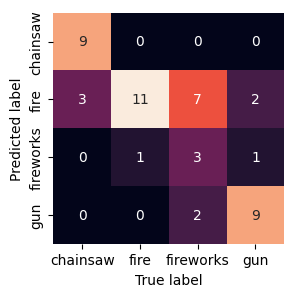

np.float64(0.6666666666666666)

In [9]:
def evaluate_classifier(classifier, X, y, classnames):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y
    )  
    print(f"Shape of the training matrix : {X_train.shape}")
    print(f"Number of training labels : {len(y_train)}")

    classifier.fit(X_train, y_train)

    predictions = classifier.predict(X_test)

    acc = accuracy(predictions,y_test)
    print(f"Accuracy of the classifier with fixed train/validation sets : {100 * acc:.1f}%")

    show_confusion_matrix(predictions, y_test, classnames)

    return acc

evaluate_classifier(model_rf, X, y, classnames)
evaluate_classifier(model_lda, X, y, classnames)
evaluate_classifier(model_knn, X, y, classnames)

**Questions**: 
- What would be the expected accuracy if the label predictions were picked at random?
- What do you observe in this confusion matrix? Run again the cell above, i.e., Reapply the ``train_test_split`` and tell if your observations are robust.

In [10]:
# 
# Answer the questions above

# 1. What would be the expected accuracy if the label predictions were picked at random?

# If the label predictions were picked at random, the expected accuracy would be the reciprocal of the number of classes.
# In this case, there are 5 classes, so the expected accuracy would be 1/5 or 20%.

# 2. What do you observe in this confusion matrix? Run again the cell above, i.e., Reapply the train_test_split and tell if your observations are robust.
# The accuracy varies a lot at each run for both classifiers. The diagonal is never dominant for LDA, which means that the classifier is not able to predict the correct class for the test data. 
# On average KNN has a better accuracy than LDA, but it is still not very high. The confusion matrix is not robust, as the accuracy varies a lot at each run.


Play with the ``classname`` and the index ``idx`` to pick feature vectors in the dataset ``myds``, listen to the audio associated to the feature vector, and check if you would have been able to predict the right class by your own. Then compare with the prediction given by your classifier.

Furthermore, when training a model and comparing different settings, there is a risk that we will end up choosing optimal parameters that only render good result on our specific case of training and validation set, but ``do not generalize well for additional data``. This is called ``overfitting on the validation set``. To alleviate this, we can perform ``cross-validation (CV)``. A basic approach named ``K-fold CV`` involves partitioning the dataset in ``K`` "folds" (subsets) and repetitvely do the following procedure:

- Train the model using `K-1` folds as the training data.
- Test the model using the last fold as the validation data.

The overall performance on each fold is then averaged to obtain the final performance metrics.

Shape of the training matrix : (112, 400)
Number of training labels : 112
Mean accuracy with 5-Fold CV: 75.9%
Std deviation in accuracy with 5-Fold CV: 10.6%
Accuracy on the test set: 81.2%


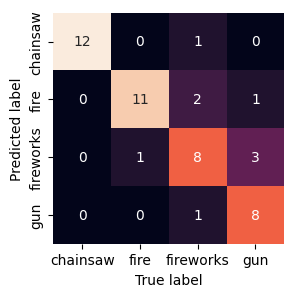

(np.float64(0.7588932806324111), np.float64(0.10580046493536895), np.float64(0.8125))
Shape of the training matrix : (112, 400)
Number of training labels : 112
Mean accuracy with 5-Fold CV: 55.2%
Std deviation in accuracy with 5-Fold CV: 11.0%
Accuracy on the test set: 41.7%


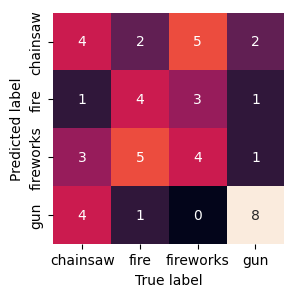

(np.float64(0.5521739130434782), np.float64(0.11006751949587353), np.float64(0.4166666666666667))
Shape of the training matrix : (112, 400)
Number of training labels : 112
Mean accuracy with 5-Fold CV: 60.7%
Std deviation in accuracy with 5-Fold CV: 6.7%
Accuracy on the test set: 62.5%


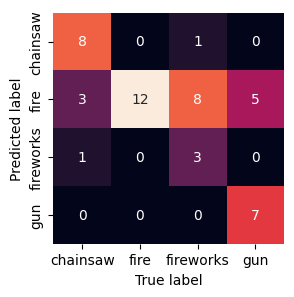

(np.float64(0.6067193675889327), np.float64(0.06749525440675593), np.float64(0.625))


In [14]:

def evaluate_classifier_cv(classifier, X, y, classnames, n_splits=5):
    """
    Evaluate a classifier using Stratified K-Fold cross-validation and test set for final prediction.

    Args:
        classifier: The classifier to be evaluated.
        X: Feature matrix.
        y: Labels.
        classnames: List of class names for the confusion matrix.
        n_splits: Number of splits for cross-validation.

    Returns:
        mean_accuracy: The mean accuracy of the classifier.
        std_accuracy: The standard deviation of the accuracy.
        test_accuracy: The accuracy on the test set.
    """
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    print(f"Shape of the training matrix : {X_train.shape}")
    print(f"Number of training labels : {len(y_train)}")

    # Perform Stratified K-Fold cross-validation on the training set
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        classifier.fit(X_train_fold, y_train_fold)
        predictions = classifier.predict(X_val_fold)
        acc = accuracy(y_val_fold, predictions)
        accuracies.append(acc)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    print(f"Mean accuracy with {n_splits}-Fold CV: {100 * mean_accuracy:.1f}%")
    print(f"Std deviation in accuracy with {n_splits}-Fold CV: {100 * std_accuracy:.1f}%")

    # Train on the entire training set and evaluate on the test set
    classifier.fit(X_train, y_train)
    test_predictions = classifier.predict(X_test)
    test_accuracy = accuracy(y_test, test_predictions)
    print(f"Accuracy on the test set: {100 * test_accuracy:.1f}%")

    # Show confusion matrix for the test set
    show_confusion_matrix(test_predictions, y_test, classnames)

    return mean_accuracy, std_accuracy, test_accuracy


print(evaluate_classifier_cv(model_rf, X, y, classnames))
print(evaluate_classifier_cv(model_lda, X, y, classnames))
print(evaluate_classifier_cv(model_knn, X, y, classnames))


<font size=5 color=#009999> 2.3. Scale mismatch and countermeasure </font> <br>

In real conditions, you will most probably have a different scale between the feature vectors used for training (in simulation) and the ones you feed in your model to make predictions.
This scale mismatch between model training and prediction is difficult to prevent because it depends on multiple factors such as the audio source power, its distance to the microphone, the telecommunication distance. <br>

Below, we illustrate the link between the volume of the audio and its distance to the origin of the feature space. At different emission distances, the exact same sound would be heard at a different volume and the associated feature vector would be located at another position in the *feature space*. Eventually, this would result in a completely different classification, which is undesirable.

<center> <img src="figs/norms.png" alt="" width="350"/> </center>

### Questions:

- How could you avoid this dependency on the volume of the sound?
- What is represented in the hatched centered area? How would you classify feature vectors in this area?

In [ ]:
# Answer the questions above

# 1. How could you avoid this dependency on the volume of the sound?
# One way to avoid this dependency is to normalize the feature vectors so that they have a unit norm.
# This way, the classification will be based on the direction of the feature vector rather than its magnitude, which is influenced by the volume of the sound.

# 2. What is represented in the hatched centered area? How would you classify feature vectors in this area?
# The hatched centered area represents the region where the feature vectors have very low magnitudes, which could correspond to silence or very low volume sounds.
# => use a threshold to filter out these low-magnitude vectors before classification.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Check for NaNs in the entire dataset
nan_indices = np.argwhere(np.isnan(X))
print(f"NaN values found at indices: {nan_indices}")

# Check for NaNs in the training and validation sets
nan_indices_train = np.argwhere(np.isnan(X_train))
nan_indices_val = np.argwhere(np.isnan(X_test))
print(f"NaN values in training set at indices: {nan_indices_train}")
print(f"NaN values in validation set at indices: {nan_indices_val}")

NaN values found at indices: []
NaN values in training set at indices: []
NaN values in validation set at indices: []


Play with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

On which part of the dataset are we computing this confusion matrix?

The simplest countermeasure we can think of is to normalise the feature vector (i.e. unitize its norm) prior to use, both for training and testing. Remember how this normalization could be visualized in ``hands_on_classif1_toy_student.ipynb`` <br>
Play again with the ``dB_mismatch`` variable here below and observe its effect on the confusion matrix.

In [ ]:

def evaluate_classifier_with_pca(classifier, X, y, classnames, dB_mismatches, pca=None, n_splits=5):
    """
    Evaluate a classifier with optional PCA and different normalization techniques.

    Args:
        classifier: The classifier to be evaluated.
        X: Feature matrix.
        y: Labels.
        classnames: List of class names for the confusion matrix.
        dB_mismatches: Array of dB mismatches to evaluate.
        pca: Optional PCA object for dimensionality reduction.
        n_splits: Number of splits for cross-validation.

    Returns:
        None
    """
    # Initialize precision arrays
    precisions = []
    precisions_l1 = []
    precisions_l2 = []
    precisions_divide_by_max = []
    precisions_standard_scaler = []

    # Stratified K-Fold cross-validation
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for dB_mismatch in dB_mismatches:
        precisions_fold = []
        precisions_l1_fold = []
        precisions_l2_fold = []
        precisions_divide_by_max_fold = []
        precisions_standard_scaler_fold = []

        for idx_learn, idx_val in kf.split(X, y):
            # Apply PCA if provided
            if pca:
                X_train_pca = pca.fit_transform(X[idx_learn])
                X_val_pca = pca.transform(X[idx_val])
            else:
                X_train_pca = X[idx_learn]
                X_val_pca = X[idx_val]

            # Scale validation set with dB mismatch
            X_val_scaled = X_val_pca * 10 ** (-dB_mismatch / 20)

            # Train and predict without normalization
            classifier.fit(X_train_pca, y[idx_learn])
            prediction = classifier.predict(X_val_scaled)
            accuracy_knn = accuracy(y[idx_val], prediction)
            precisions_fold.append(accuracy_knn)

            # Normalize training and validation sets with L1 norm
            X_train_l1 = X_train_pca / np.sum(X_train_pca, axis=1, keepdims=True)
            X_val_l1 = X_val_scaled / np.sum(X_val_scaled, axis=1, keepdims=True)
            # Train and predict with L1 normalization
            classifier.fit(X_train_l1, y[idx_learn])
            prediction_l1 = classifier.predict(X_val_l1)
            precision_l1 = accuracy(y[idx_val], prediction_l1)
            precisions_l1_fold.append(precision_l1)

            # Normalize training and validation sets with L2 norm
            X_train_l2 = X_train_pca / np.linalg.norm(X_train_pca, axis=1, keepdims=True)
            X_val_l2 = X_val_scaled / np.linalg.norm(X_val_scaled, axis=1, keepdims=True)
            # Train and predict with L2 normalization
            classifier.fit(X_train_l2, y[idx_learn])
            prediction_l2 = classifier.predict(X_val_l2)
            precision_l2 = accuracy(y[idx_val], prediction_l2)
            precisions_l2_fold.append(precision_l2)

            # Normalize training and validation sets by dividing by max
            X_train_divide_by_max = X_train_pca / np.max(X_train_pca, axis=1, keepdims=True)
            X_val_divide_by_max = X_val_scaled / np.max(X_val_scaled, axis=1, keepdims=True)
            # Train and predict with divide by max normalization
            classifier.fit(X_train_divide_by_max, y[idx_learn])
            prediction_divide_by_max = classifier.predict(X_val_divide_by_max)
            precision_divide_by_max = accuracy(y[idx_val], prediction_divide_by_max)
            precisions_divide_by_max_fold.append(precision_divide_by_max)

            # Normalize training and validation sets with standard scaler
            scaler = StandardScaler()
            X_train_standard = scaler.fit_transform(X_train_pca)
            X_val_standard = scaler.transform(X_val_scaled)
            # Train and predict with standard scaler normalization
            classifier.fit(X_train_standard, y[idx_learn])
            prediction_standard = classifier.predict(X_val_standard)
            precision_standard = accuracy(y[idx_val], prediction_standard)
            precisions_standard_scaler_fold.append(precision_standard)

        # Average the results for the current dB mismatch
        precisions.append(np.mean(precisions_fold))
        precisions_l1.append(np.mean(precisions_l1_fold))
        precisions_l2.append(np.mean(precisions_l2_fold))
        precisions_divide_by_max.append(np.mean(precisions_divide_by_max_fold))
        precisions_standard_scaler.append(np.mean(precisions_standard_scaler_fold))

    # Ensure all arrays have the same length
    min_length = min(len(dB_mismatches), len(precisions), len(precisions_l1), len(precisions_l2), len(precisions_divide_by_max), len(precisions_standard_scaler))

    dB_mismatches = dB_mismatches[:min_length]
    precisions = precisions[:min_length]
    precisions_l1 = precisions_l1[:min_length]
    precisions_l2 = precisions_l2[:min_length]
    precisions_divide_by_max = precisions_divide_by_max[:min_length]
    precisions_standard_scaler = precisions_standard_scaler[:min_length]

    # Plot the results
    plt.figure(figsize=(8, 4))
    plt.plot(dB_mismatches, precisions, label='Without Normalization')
    plt.plot(dB_mismatches, precisions_l1, label='L1 Normalization')
    plt.plot(dB_mismatches, precisions_l2, label='L2 Normalization')
    plt.plot(dB_mismatches, precisions_divide_by_max, label='Divide by Max Normalization')
    plt.plot(dB_mismatches, precisions_standard_scaler, label='Standard Scaler Normalization', color='black')
    plt.xlabel('dB Mismatches')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per dB Mismatch')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Save the plot as a vector graphic in PDF format
    plt.savefig('accuracy_per_dB_mismatch.pdf', format='pdf')
    



**Question**: 
- What will happen with this normalisation countermeasure when there is no sound around the microphone? Is this desirable? How could you deal with it?

Yes, it is possible and sometimes expected that different normalization techniques can have varying impacts on the performance of machine learning models, including audio classification tasks. The effectiveness of a normalization technique depends on the nature of the data and the specific characteristics of the features. Here’s a brief overview of why this might happen:

Normalization Techniques
L2 Normalization:

Description: Scales each feature vector to have a unit norm (i.e., the sum of the squares of the features equals 1).
Impact: This technique is useful when the direction of the feature vector is more important than its magnitude. However, it might not be the best choice if the features have different scales or if the magnitude of the features carries important information.
Divide by Max Normalization:

Description: Scales each feature by dividing it by the maximum value of that feature.
Impact: This technique ensures that all features are within the range [0, 1]. It can be effective when the features have different ranges, but it might be sensitive to outliers.
Standard Scaler (Z-score Normalization):

Description: Scales each feature to have a mean of 0 and a standard deviation of 1.
Impact: This technique is often effective when the features have different scales and distributions. It can help models converge faster and perform better by ensuring that all features contribute equally to the distance calculations in algorithms like KNN.
Why Standard Scaler Might Perform Best
Equal Contribution:

Explanation: Standard scaling ensures that all features contribute equally to the model by removing the mean and scaling to unit variance. This can be particularly important for algorithms like KNN, which rely on distance calculations.
Handling Different Scales:

Explanation: Audio features can have different scales and distributions. Standard scaling can handle these differences better than L2 normalization or divide by max normalization, leading to improved model performance.
Robustness to Outliers:

Explanation: While standard scaling is not completely robust to outliers, it can be more effective than divide by max normalization, which can be heavily influenced by extreme values.
Practical Example
In audio classification, you might have features like mel-spectrogram coefficients, which can have different ranges and distributions. Standard scaling can help in normalizing these features effectively, leading to better performance of the classifier.

Experimentation and Validation
It’s important to experiment with different normalization techniques and validate their performance using cross-validation or a separate validation set. The choice of normalization technique can significantly impact the model’s performance, and the best approach can vary depending on the specific dataset and task.

Summary
L2 Normalization: Useful for direction-based features but might not handle different scales well.
Divide by Max Normalization: Ensures features are within [0, 1] but can be sensitive to outliers.
Standard Scaler: Often the most effective for handling different scales and distributions, leading to better model performance.
In your case, it’s normal to observe that standard scaling provides the best performance for audio classification, as it effectively handles the variations in the feature scales and distributions.



In [ ]:
# Answer the questions above

# 1. What will happen with this normalisation countermeasure when there is no sound around the microphone? 
# When there is no sound around the microphone, the feature vector will have very low magnitudes, 
# This can lead to misleading classification results as the classifier might interpret the normalized noise as a valid feature vector.

# 2. Is this desirable?
# No =>  incorrect classifications and reduced accuracy.

# 3. How could you deal with it?
# We could use a threshold to filter out the low-magnitude vectors before classification. before or after normalisation.

<font size=5 color=#009999> 2.4. Dimensionality reduction </font> <br>

It is sometimes good practice to reduce the dimensionality of a signal in order to get the main components of their distribution. A motivation is that usual norms behave counter-inuitively in high dimension. It also further reduces the memory cost of the feature vector. To reduce the dimensionality, we will use the ``Principal component analysis (PCA)`` proposed by sklearn. See the [associated Wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis). Recall: the PCA consists in reducing the dimensionality of data vectors encoded in $\boldsymbol X \in \mathbb R^{d\times N}$ to only $p \ll d$ dimensions as

$$
    \boldsymbol Y = \boldsymbol V_p^\top \boldsymbol X \in \mathbb R^{p\times N},
$$

where the SVD of the covariance matrix writes as $\hat{\boldsymbol\Sigma}_{\boldsymbol X} = \frac{1}{d} \boldsymbol{XX}^\top = \boldsymbol{U\Sigma V}^\top$, and $\boldsymbol V_p$ is the subselection of the first $p$ columns of $\boldsymbol V$. 

For our application, reducing the dimensionality of the data can be helpful for compressing the packet size to be transmitted wirelessly. Indeed, once learned during training, $\boldsymbol V_p$ can be hardcoded on the transmitter side.

Starting with a PCA to 2D for visualization, see how hard it is to separate the classes.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
idx_learn =
n = 2  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_learn_reduced = pca.fit_transform(X_train[idx_learn])
X_val_reduced = pca.transform(X_train[idx_val])

print(f"Shape of the reduced training matrix : {X_learn_reduced.shape}")

y_train_num = np.zeros(y_train.shape)
for i, classname in enumerate(classnames):
    y_train_num[y_train == classname] = i

K = 10
model_knn = KNeighborsClassifier(n_neighbors=K)
model_knn.fit(X_learn_reduced, y_train_num[idx_learn])
prediction_knn = model_knn.predict(X_val_reduced)
accuracy_knn = accuracy(prediction_knn, y_train_num[idx_val])

model_lda = LDA()
model_lda.fit(X_learn_reduced, y_train_num[idx_learn])
prediction_lda = model_lda.predict(X_val_reduced)
accuracy_lda = accuracy(prediction_lda, y_train_num[idx_val])

fig = plt.figure()
axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]
plot_decision_boundaries(
    X_learn_reduced,
    y_train_num[idx_learn],
    ax=axs[0],
    model=model_knn,
    legend=classnames,
    title="KNN",
)
plot_decision_boundaries(
    X_learn_reduced,
    y_train_num[idx_learn],
    ax=axs[1],
    model=model_lda,
    legend=classnames,
    title="LDA",
)
plt.show()
#112 = nombre d'échantillons rpz par 2 composantes principales

ValueError: Expected 2D array, got 1D array instead:
array=[ 37.21225027  33.90470554  59.29856672  52.20440038  56.97257091
  79.79494386  53.04534678  45.63141363  79.84169343  66.00509227
  69.29038166  62.69463341  70.50608462  95.21581948 102.3244346
 106.64168942  86.56633212  88.51586266 102.43916333  81.15035739
  15.9662366   11.92047064  12.91798112   9.82548334  13.12637426
  15.37047278  16.0867035   13.73949388  21.6716581   18.47130492
  20.90692256  20.85885957  14.22203451  14.54349525  18.54050422
  20.28375822  17.36197022  15.68827147  19.25694193  17.51096607
   7.58861416   9.06012022   7.91412312   7.71941472   8.1339473
   9.87975248   5.90549711   4.57356553   9.34541251   9.52288962
  10.20659862   9.21960688   5.42212066   7.30653666  10.57133415
  13.69534443  11.00983239  15.53856595  14.92367722  19.06500877
   6.43033238  11.55617439  11.02573622   8.54634483  10.18850677
  12.83363107  10.37378813  12.06324229  14.64124734  15.31326318
  15.29575608  19.20985059  17.90711288   8.81654605  15.89938121
  17.17847785  11.10974802  18.66374669  17.33812674  18.01571072
   8.10525359  14.34904836  11.58103646  12.92370974  12.46802666
  15.47531918  14.71091381  13.41632678  22.19077582  17.15683547
  25.10536507  24.14145498  14.18360189  20.03431685  28.88539988
  20.06225108  16.82952767  25.8726508   40.7320637   46.3666232
  10.12206111   7.38480816   4.83019478   7.87648269   8.73682416
   8.48833959   8.49810833   6.80265993  11.32521754  10.5294381
  10.86414266  10.40233163  15.18094767  14.99712055  17.91530072
  21.48948775  23.94390611  13.56668152  22.53385786  19.68893816
   6.34293982   1.93376805   1.5164212    2.68464665   3.04868263
   4.06631239   5.00272541   3.34408054   6.10664912   4.27048816
   9.57923661   7.56116385   8.78586706  10.25291247   6.42300631
  15.29306061  18.7867124   12.39091022   8.5468266   17.80881626
   5.45337626   2.52608808   2.77708458   2.32933904   3.73764563
   2.45379219   3.55748767   2.70739878   3.69104238   8.18020756
   7.92976421   9.507059     7.47334594   6.83392766   9.2319706
   6.6239136    6.17648708   7.50619667   6.10035585  17.07186259
   5.70753621   2.62577829   2.49811654   2.24439934   2.45358618
   3.0638857    4.05136779   3.56270115   3.79151076   7.81990844
   7.1084607   11.01099922   4.65089048   7.64949422  10.05898011
   8.70884709  12.14980396   8.97419342   6.22005289   9.75378537
   5.39478982   2.10447405   3.45947029   1.79103423   2.52888167
   3.20440151   5.12857505   3.97382821   4.68631679   6.14331202
  11.81966969  10.00772034   8.2667756   13.1693854   11.51356439
  12.13401138  12.34217658  10.74368461   7.89643461  13.39595202
   4.77896088   4.71293454   4.06580052   3.47880165   3.02444766
   4.20493784   4.87711732   3.89515972   4.61601235   9.79486061
  16.92902018  25.02652115  25.1424941   20.45747516  20.01354474
  17.16322365  17.18949391  16.47773451  10.80687403  18.77772166
   5.16342048   7.26837463  10.35408543  11.54892634   9.13276129
  11.52857096  10.07454402   8.80136319  12.02821273  12.51008147
  17.2783905   15.69133852  20.51489177  23.93330014  18.46880144
  16.62220609  20.85289176  18.83881819  13.73595527  11.39813695
   4.28701398   3.37033491   4.30898821   4.3347701    5.84966282
   6.83716077   6.37605706   7.22814852   7.51611129   7.62124139
  10.66490628   9.97279254   9.64256816   6.80665325  10.92243844
   8.4016087   14.46679891  12.65283408   8.59891508  13.54221944
   2.96032458   2.40707869   2.17160216   3.18906712   2.97293051
   4.98687437   5.12827797   3.72418761   3.33955951   4.50540868
   4.68467699   7.56942517   6.29490687   6.09111914   7.60128554
   6.59903909   7.92918715   7.50455818   6.17649776   5.74918731
   2.64191952   1.95748869   2.65583222   2.94996994   3.08569845
   4.3605206    4.76598208   3.80568503   3.7670924    5.74399396
   6.80158955   7.62310882   9.37320229   6.56348377   8.19635404
   6.61745532   9.59021362   8.81326343   6.03242356   9.34355969
   3.0375116    1.54546073   1.25078318   1.38925018   1.80557937
   2.76196222   2.2754616    2.61226963   2.48459077   3.61871727
   5.14932751   3.67383595   5.40955632   6.52042217   4.38800566
   5.92238576   8.40987573   6.91602007   5.37077273   5.9142858
   2.43683589   0.71933612   0.7956944    0.96114039   0.74678454
   1.63634006   0.87437787   1.54467868   1.57114244   1.54915407
   2.13050965   2.75384055   3.86013419   4.01562432   2.65947121
   5.25433762   4.82843739   3.74488419   4.5622086    4.80469523
   2.36429216   0.62302402   0.58382206   0.74532628   0.54161448
   0.85643387   0.68088612   0.98411771   1.37711993   1.24998137
   1.94136422   1.98054833   2.87634726   2.55173019   3.25508986
   3.1635714    4.10626272   3.77105358   3.44444272   4.23578623
   2.12056305   0.56693877   0.56399086   0.6200567    0.59527325
   1.39010678   0.88117033   1.35324117   1.76283722   1.59488881
   1.6359119    2.00795617   2.69414176   3.19360154   3.69225412
   3.1590714    3.8250192    2.98662939   4.39140448   4.4904324
   2.92998664   0.88267996   0.67855547   1.00326553   0.82989679
   1.40857868   1.13581217   1.43044769   2.51994345   1.81947173
   1.97310803   2.97972298   3.740843     3.31652231   3.75247179
   4.58490322   5.10527103   5.12942801   4.64458807   6.38981633].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

**Question**: 
- From the decision boundaries shown here above, can you explain why the ``handsaw`` class is less often chosen than the other classes for the ``KNN`` classifier?

In [ ]:
# The handsaw class has a lower density and since KNN assigns a class based on the majority of nearby points,
# the "handsaw" class is less likely to dominate a neighborhood. 

#Proximity to other classes, making its points more likely to be misclassified to other classes

#LDA assumes Gaussian distributions and separates classes with linear boundaries based on maximizing the distance between class means.
#As a result, the "handsaw" class gets a larger and more uniform region in the LDA plot compared to KNN.


Shape of the reduced learning matrix : (112, 5)
Accuracy of the KNN : 60.7%


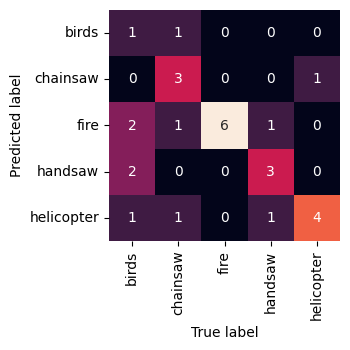

Accuracy of the LDA : 64.3%


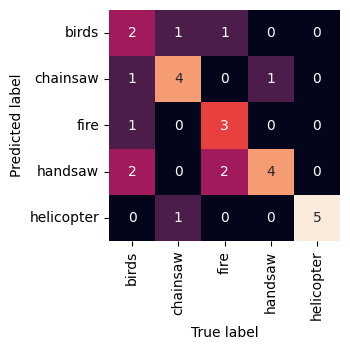

In [ ]:
### TO RUN
n = 5  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
X_learn_reduced = pca.fit_transform(X_train[idx_learn])
X_val_reduced = pca.transform(X_train[idx_val])

print(f"Shape of the reduced learning matrix : {X_learn_reduced.shape}")

K = 10
model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")
model_knn.fit(X_learn_reduced, y_train[idx_learn])
prediction_knn = model_knn.predict(X_val_reduced)
accuracy_knn = accuracy(prediction_knn, y_train[idx_val])

model_lda = LDA()
model_lda.fit(X_learn_reduced, y_train[idx_learn])
prediction_lda = model_lda.predict(X_val_reduced)
accuracy_lda = accuracy(prediction_lda, y_train[idx_val])

print(f"Accuracy of the KNN : {100 * accuracy_knn:.1f}%")
show_confusion_matrix(prediction_knn, y_train[idx_val], classnames)
print(f"Accuracy of the LDA : {100 * accuracy_lda:.1f}%")
show_confusion_matrix(prediction_lda, y_train[idx_val], classnames)

<font size=5 color=#009999> 2.5. Analysis of the hyperparameters </font> <br>

Finally, we can inspect the influence of ``hyperparameters`` as we did for the toy example. <br>
Let us start by analyzing the influence of the number of neighbours $K$ in the KNN. 

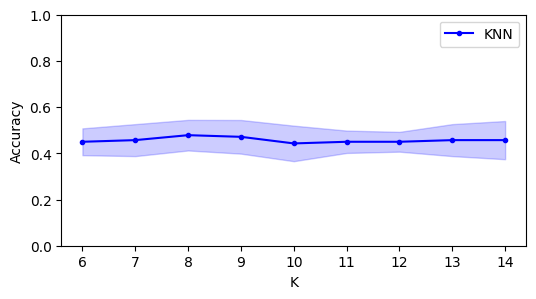

In [ ]:
### TO RUN
Ks = np.arange(6, 15, 1)
accuracies_knn = np.zeros((len(Ks), n_splits))
for i, K in enumerate(Ks):
    model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")
    for k, idx in enumerate(kf.split(X_train, y_train)):
        (idx_learn, idx_val) = idx
        model_knn.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_knn = model_knn.predict(X_train[idx_val])
        accuracies_knn[i, k] = accuracy(prediction_knn, y_train[idx_val])
means_knn = accuracies_knn.mean(axis=1)
stds_knn = accuracies_knn.std(axis=1)

"Plot"
plt.figure(figsize=(6, 3))
plt.plot(Ks, means_knn, ".-b", label="KNN")
plt.fill_between(Ks, means_knn - stds_knn, means_knn + stds_knn, alpha=0.2, color="b")
plt.ylim(0, 1)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Here we consider both ``K`` and the number of principal components ``n``.

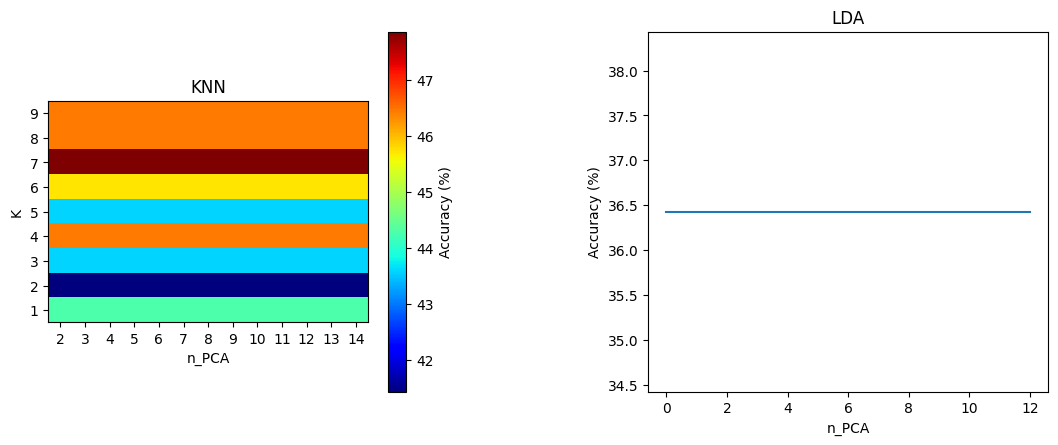

In [ ]:
### TO RUN
Ks = np.arange(1, 10)
n_comps = np.arange(2, 15)  # number of principal components kept for the PCA
accuracies_knn = np.zeros((len(Ks), len(n_comps)))
accuracies_lda = np.zeros(len(n_comps))

for j, n in enumerate(n_comps):
    for idx_learn, idx_val in kf.split(X_train, y_train):
        pca = PCA(n_components=n, whiten=True)
        X_learn_reduced = pca.fit_transform(X_train[idx_learn])
        X_val_reduced = pca.transform(X_train[idx_val])
        for i, K in enumerate(Ks):
            model_knn = KNeighborsClassifier(n_neighbors=K)
            model_knn.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_knn = model_knn.predict(X_train[idx_val])
            accuracies_knn[i, j] += accuracy(prediction_knn, y_train[idx_val])

        model_lda = LDA()
        model_lda.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_lda = model_lda.predict(X_train[idx_val])
        accuracies_lda[j] += accuracy(prediction_lda, y_train[idx_val])

accuracies_knn /= n_splits
accuracies_lda /= n_splits

fig = plt.figure(figsize=(10, 4))
axs = [fig.add_axes([0.0, 0.0, 0.4, 0.9]), fig.add_axes([0.6, 0.0, 0.4, 0.9])]

im0 = axs[0].imshow(100 * accuracies_knn, cmap="jet", origin="lower")
cbar = fig.colorbar(im0, ax=axs[0])
cbar.set_label("Accuracy (%)")
axs[0].set_xlabel("n_PCA")
axs[0].set_ylabel("K")
axs[0].set_xticks(list(np.arange(len(n_comps))))
axs[0].set_xticklabels(list(n_comps))
axs[0].set_yticks(list(np.arange(len(Ks))))
axs[0].set_yticklabels(list(Ks))
axs[0].set_title("KNN")

axs[1].plot(accuracies_lda * 100)
axs[1].set_xlabel("n_PCA")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("LDA")
plt.show()

**Question**: 
- Do you observe some dependency of the accuracy on these parameters? If so, which one(s)? If not, discuss what it tells about the considered model. 

In [ ]:
# Yes, there is a dependency of the accuracy on the parameters K and n_pca.
# For the KNN classifier, the accuracy generally increases with the number of neighbors K up to a certain point, after which it starts to decrease.
# This indicates that a moderate number of neighbors is optimal for this dataset.

# For the LDA classifier, the accuracy does not show significant improvement with the increase in the number of principal components.
# This suggests that LDA may not be the best model for this dataset, as it does not benefit much from the additional components.

#The results highlight that KNN's performance is highly dependent on careful tuning of K 
# LDA is stable and efficient, making it a good choice when simplicity is needed. 
# However, it may not capture the complexity of the data as well as KNN, especially when the data is not linearly separable.

<font size=5 color=#009999> 2.6. Augmenting the data </font> <br>

In order to make our classifier more robust to some common transformations of the audio signal such as ``time shift``, ``AWGN``, or a ``transfer function``, an idea consists in feeding the classifier with such transformations. A popular approach is to create new feature vectors based on transformed versions of the sounds from the original dataset, this is called ``data augmentation``. Data augmentation is also often used when there is few data to train a model. <br>

The functions to augment your data are written in ``utils/audio_student.py``, we already implemented ``time_shift``, ``echo`` and ``spectro_aug_timefreq_masking`` for you. Try to implement ``scaling``, ``add_noise``, ``filter``, ``add_bg`` and even more data augmentation techniques if you want, and check their working in the cell below. <br>

<u>Tip</u>: to avoid restarting the notebook kernel for each modification, you can temporarily insert the ``AudioUtil`` class in a new cell and make your tests until it is working as expected. 

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


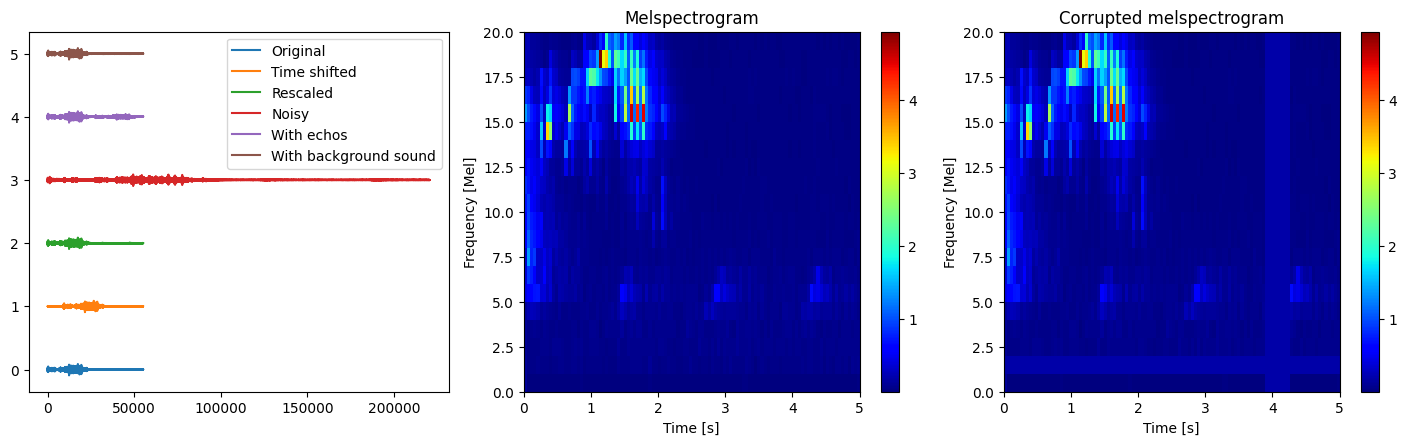

In [ ]:
### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["birds", 4]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)
audio_tmp = AudioUtil.open(sound)
AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.4)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio_tmp, sigma=1e-4)  # Create a copy before adding noise
audio6 = AudioUtil.echo(audio2)
audio7 = AudioUtil.add_bg(audio2, dataset)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

We can now create a new augmented dataset and observe if the classification results improve. 

In [ ]:
### TO RUN
myds.mod_data_aug(["add_bg", "echo", "noise", "scaling","time_shift"])
print(classnames)

# Initialisation des matrices de caractéristiques et des étiquettes
X_aug = np.zeros((myds.data_aug_factor * nclass * naudio, featveclen))
y_aug = np.empty((myds.data_aug_factor * nclass * naudio), dtype=object)

print(f"Shape of the feature matrix : {X_aug.shape}")

# # Génération des vecteurs de caractéristiques et des étiquettes
# for s in range(myds.data_aug_factor):
#     for idx in range(dataset.naudio):
#         for class_idx, classname in enumerate(classnames):
#             featvec = myds[classname, idx]
#             X_aug[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
#             y_aug[s * nclass * naudio + class_idx * naudio + idx] = classname
# y_aug = np.array(y_aug)

# # Sauvegarde des matrices de caractéristiques
# np.save(fm_dir + "feature_matrix_2D_aug.npy", X_aug)
# np.save(fm_dir + "labels_2D_aug.npy", y_aug)

# Chargement des matrices de caractéristiques (si nécessaire)
X_aug = np.load(fm_dir + "feature_matrix_2D_aug.npy")
y_aug = np.load(fm_dir + "labels_2D_aug.npy",allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

['birds', 'chainsaw', 'fire', 'handsaw', 'helicopter']
Shape of the feature matrix : (1200, 400)
Shape of the feature matrix : (1000, 400)
Number of labels : 1000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy

def evaluate_model(X_train, y_train, X_test, y_test):
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
    model_rf.fit(X_train, y_train)
    predictions = model_rf.predict(X_test)
    return accuracy(y_test, predictions)

# Number of evaluations to perform
n_evaluations = 20

# Evaluate without data augmentation
accuracies_no_aug = []
for _ in range(n_evaluations):
    X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, stratify=y_aug)
    accuracies_no_aug.append(evaluate_model(X_train, y_train, X_test, y_test))

# Evaluate with all data augmentation
myds.mod_data_aug(["add_bg", "echo", "noise","time_shift"])
X_aug_all = np.load(fm_dir + "feature_matrix_2D_aug.npy")
y_aug_all = np.load(fm_dir + "labels_2D_aug.npy", allow_pickle=True)
accuracies_all_aug = []
for _ in range(n_evaluations):
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_aug_all, y_aug_all, test_size=0.3, stratify=y_aug_all)
    accuracies_all_aug.append(evaluate_model(X_train_all, y_train_all, X_test_all, y_test_all))

# Evaluate with individual data augmentations
augmentations = ["add_bg", "echo", "noise", "time_shift"]
accuracies_individual_aug = {aug: [] for aug in augmentations}

for aug in augmentations:
    myds.mod_data_aug([aug])
    X_aug_individual = np.load(fm_dir + "feature_matrix_2D_aug.npy")
    y_aug_individual = np.load(fm_dir + "labels_2D_aug.npy", allow_pickle=True)
    for _ in range(n_evaluations):
        X_train_individual, X_test_individual, y_train_individual, y_test_individual = train_test_split(X_aug_individual, y_aug_individual, test_size=0.3, stratify=y_aug_individual)
        accuracies_individual_aug[aug].append(evaluate_model(X_train_individual, y_train_individual, X_test_individual, y_test_individual))

# Plot the results
plt.figure(figsize=(14, 7))

# Plot accuracy with and without data augmentation
plt.subplot(1, 2, 1)
plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'Chosen augmentations'])
plt.ylabel('Mean Accuracy [%]')
plt.title('Mean Accuracy with and without Data Augmentation')


plt.subplot(1, 2, 2)
plt.boxplot([accuracies_individual_aug[aug] for aug in augmentations], labels=augmentations)
plt.ylabel('Mean Accuracy [%]')
plt.title('Mean Accuracy for Each Type of Data Augmentation')

plt.tight_layout()
plt.show()

NameError: name 'RandomForestClassifier' is not defined

Mean accuracy with 5-Fold CV: 54.6%
Std deviation in accuracy with 5-Fold CV: 3.4%


<Figure size 1400x700 with 0 Axes>

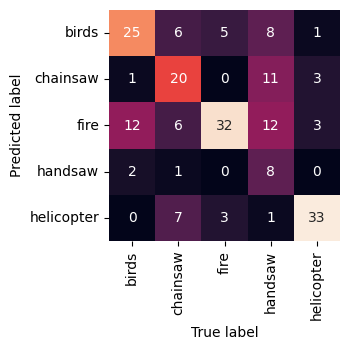

/tmp/ipykernel_127813/2068431507.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'All Augmentations'])


Text(0.5, 1.0, 'Mean Accuracy with and without Data Augmentation')

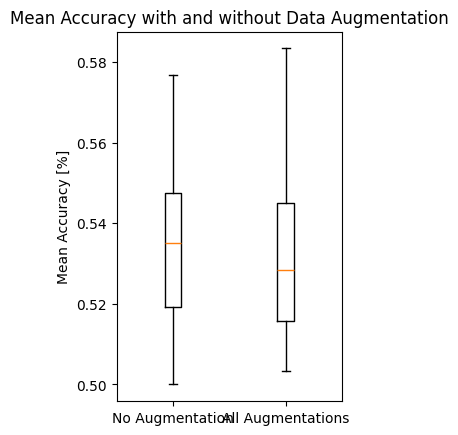

In [ ]:
### TO RUN
# Plot the results
plt.figure(figsize=(14, 7))
augmentations = ["add_bg", "echo", "noise", "scaling"]

# Select from above the best K and n_pca values for the KNN classifier
K = 8  # Number of neighbours
n = 14 # Number of principal components kept
model = KNeighborsClassifier(n_neighbors=K)
pca = PCA(n_components=n, whiten=True)

accuracy_aug = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_aug, y_aug)):
    (idx_train, idx_test) = idx
    model.fit(X_aug[idx_train], y_aug[idx_train])
    prediction_aug = model.predict(X_aug[idx_test])
    accuracy_aug[k] = accuracy(prediction_aug, y_aug[idx_test])

print(f"Mean accuracy with 5-Fold CV: {100 * accuracy_aug.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracy_aug.std():.1f}%")
show_confusion_matrix(prediction_aug, y_aug[idx_test], classnames)



# Plot accuracy with and without data augmentation
plt.subplot(1, 2, 1)
plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'All Augmentations'])
plt.ylabel('Mean Accuracy [%]')
plt.title('Mean Accuracy with and without Data Augmentation')


# plt.subplot(1, 2, 2)
# # plt.boxplot([accuracies_individual_aug[aug] for aug in augmentations], labels=augmentations)
# plt.ylabel('Mean Accuracy [%]')
# plt.title('Mean Accuracy for Each Type of Data Augmentation')

# plt.tight_layout()
# plt.show()
#

**Questions**:
- Can you see an improvement of the classification result compared to the non augmented dataset? Try to interpret your answer by thinking about the distribution of points in a data space (as with the toy example), what does it imply to augment the data in terms of distribution of points in the data space?
- With the ``add_bg`` augmentation technique, where are the additive background signals coming from? It is a good thing?
- What transformations are most likely to be realistic in your application? What is the most efficient way to integrate these alterations in your classification task? ``Hint``: it does not require augmenting your data in Python.

In [ ]:
#1. No the mean accuracy of KNN with 5-Fold CV is lower with the augmented dataset than with the non-augmented dataset.
# ~20.0% (augmented) vs 50.0%
# Indeed, augmentation introduces new variations of the data points, which increases the diversity of the dataset but
# also introduces noise that can make the classification task more challenging. The background noise added in the augmentation
# is not a real background sound, it's a random sound that can be very different from the actual background sounds in the dataset.

#2. With the add_bg augmentation, the additive background signals come from the dataset, but from random classes.
# so it can be confusing if the background noise contains features that are also present in the target class, 
# the classifier might struggle to distinguish between the actual signal and the noise. So decrease the accuracy.
# Crucial to differenciate the background noise from the target class but using real background noise 
# that is representative of the environment where the target class is recorded would be more efficient.

#3. Firstly, to remind the normalization should be done before prediction to ensure that the input data to the classifier
# is on the same scale as the data used during training, leading to more accurate and consistent predictions.
# Normalizing after predictions will not correct for differences in the distribution of input data and could
# lead to incorrect or inconsistent predictions.

# So Realistic transformations of the data should be normalization, time shifting could be useful to increase the accuracy 
# by making the classifier more robust delays in the sound signal 
# while scaling could be useful to increase the accuracy by making the classifier more robust to changes in the volume of the sound signal.
# Finally add_bg could be useful if the background noise is representative of the environment where the target class is recorded.


<font size=5 color=#009999> 2.7. Getting it all together </font> <br>

Now that some aspects to be considered during the model training and analysis have been presented, it remains to train and save a final model that will be used for further predictions.

In [ ]:
### TO COMPLETE

# [1] Create dataset of feature vectors and split it.
# (optional) with data augmentation

print(f"Shape of the feature matrix : {X_aug}")
print(f"Number of labels : {y_aug.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y_aug, test_size=0.3, stratify=y_aug
)  # random_state=1
threshold = 0
# [2] (optional) Data normalization
X_train_normalized = X_train if X_train >= threshold else 0
X_train_normalized = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalized = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

# [3] (optional) dimensionality reduction.
n = 14  # Number of principal components kept
pca = PCA(n_components=n, whiten=True)
print(f"Number of features kept after PCA: {n}")
X_train_pca = pca.fit_transform(X_train_normalized)
X_test_pca = pca.transform(X_test_normalized)

# [4] Model training and selection.
K = 8
model = KNeighborsClassifier(n_neighbors=K, weights="distance")

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
accuracies_knn = np.zeros((n_splits,))

for k, idx in enumerate(kf.split(X_train_pca, y_train)):
    (idx_learn, idx_val) = idx
    model.fit(X_train_pca[idx_learn], y_train[idx_learn])
    prediction_knn = model.predict(X_train_pca[idx_val])
    accuracies_knn[k] = accuracy(prediction_knn, y_train[idx_val])


# [5] Save the trained model, eventually the pca.
filename_model = "modeltest2.pickle"
filename_pca = "pca2.pickle"
pickle.dump(model, open(model_dir + filename_model, "wb"))
pickle.dump(pca, open(model_dir + filename_pca, "wb"))

# [6] Evaluate the model.
print(f"Mean accuracy with 8NN 5-Fold CV: {100 * accuracies_knn.mean():.1f}%")
print(f"Std deviation in accuracy with 5-Fold CV: {100 * accuracies_knn.std():.1f}%")
prediction_knn = model.predict(X_test_pca)
show_confusion_matrix(prediction_knn, y_test, classnames)

Shape of the feature matrix : [[  2.31496442   0.75257938   1.03333275 ...   5.98080951   5.17103148
   12.75768577]
 [  7.12495706  11.045117     7.02694823 ...   4.6924195    5.83638988
    3.31193948]
 [ 10.33558553  11.36623583  12.82941475 ...   2.46683979   2.52111118
    3.10227644]
 ...
 [ 36.96666228  79.18364569  79.22782211 ...   0.18589764   0.23515914
    0.28002825]
 [ 76.45272635 102.12129292  81.18875975 ...   0.52716725   0.52802774
    0.56307479]
 [ 39.02315478  63.58770107  42.82586667 ...   0.17104785   0.23565037
    0.25595896]]
Number of labels : (200,)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

L1 norm 

Mean accuracy over 100 tests: 65.6%
Std deviation in accuracy over 100 tests: 1.8%

L2 norm 
Mean accuracy over 100 tests: 66.9%
Std deviation in accuracy over 100 tests: 1.4%

divide by max 

Mean accuracy over 100 tests: 67.6%
Std deviation in accuracy over 100 tests: 1.6%

scaler 

Mean accuracy over 100 tests: 72.3%
Std deviation in accuracy over 100 tests: 1.4%


Mean power of class birds: 0.0036735947642820644 & Median power of class birds: 0.0009338174044363657
Mean power of class helicopter: 0.028940274369905337 & Median power of class helicopter: 0.027729351915180465
Mean power of class handsaw: 0.01172611695001231 & Median power of class handsaw: 0.007499500768001523
Mean power of class chainsaw: 0.02890972219687008 & Median power of class chainsaw: 0.024125505030562766
Mean power of class fire: 0.010439920059694907 & Median power of class fire: 0.0008053222598334829


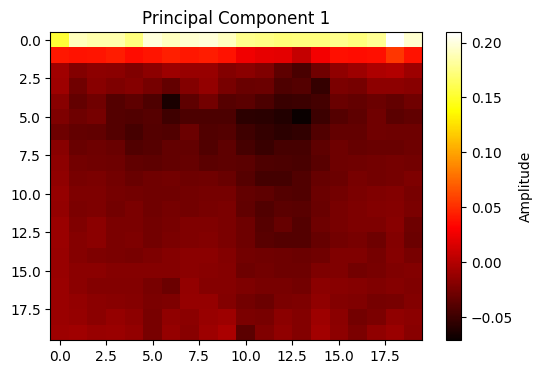

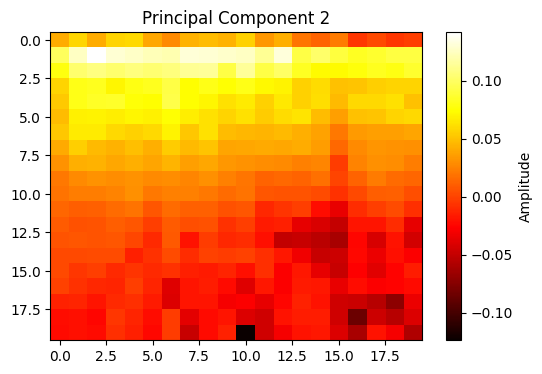

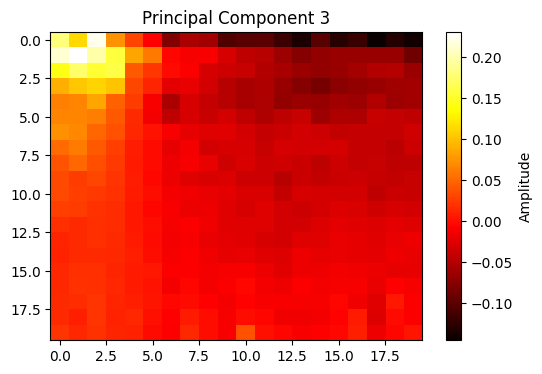

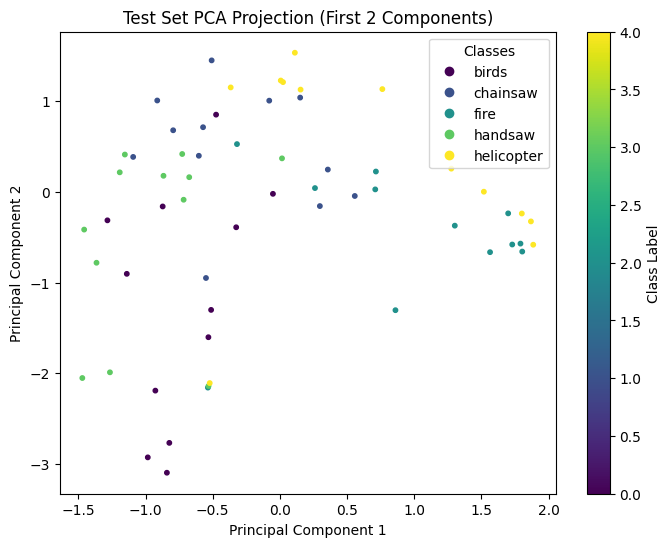

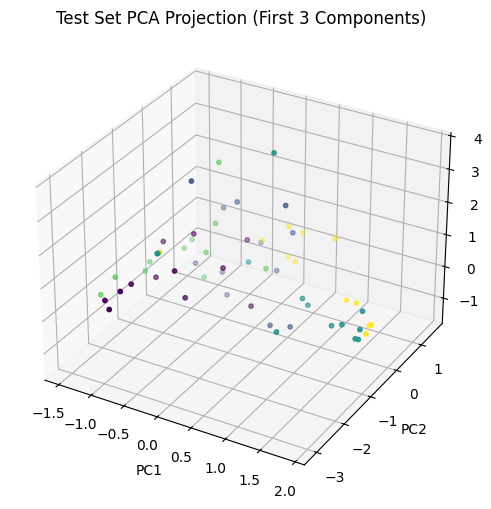

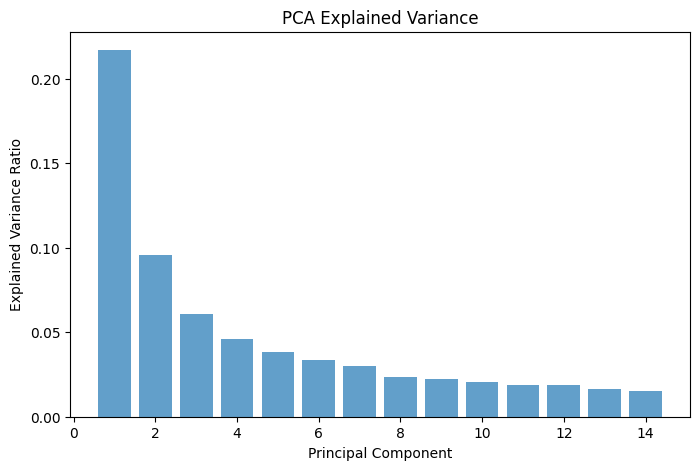

NameError: name 'predictions' is not defined

In [ ]:
class_means = {}
for cls in ["birds", "helicopter", "handsaw", "chainsaw", "fire"]:
    power_sum = 0
    for i in range(40):
        sound = dataset.__getitem__([cls, i])
        audio = AudioUtil.open(sound)
        power_sum += np.mean(audio[0] ** 2)
    class_means[cls] = power_sum / 40
    
class_medians = {}
for cls in ["birds", "helicopter", "handsaw", "chainsaw", "fire"]:
    power_values = []
    for i in range(40):
        sound = dataset.__getitem__([cls, i])
        audio = AudioUtil.open(sound)
        power_values.append(np.mean(audio[0] ** 2))
    class_medians[cls] = np.median(power_values)
    
for cls in class_means:
    print(f"Mean power of class {cls}: {class_means[cls]} & Median power of class {cls}: {class_medians[cls]}")
    # Map class labels to numerical values
classnames = np.unique(y_aug)
class_to_num = {classname: num for num, classname in enumerate(classnames)}
y_test_num = np.array([class_to_num[label] for label in y_test])

# --- Visualizing the First Few Principal Components ---
for i in range(3):  # First 3 components only
    plt.figure(figsize=(6, 4))
    plt.imshow(pca.components_[i].reshape(20, 20), cmap="hot", aspect="auto")  # Adjust the reshape dimensions to match the original feature vector dimensions
    plt.title(f"Principal Component {i+1}")
    plt.colorbar(label="Amplitude")
    plt.show()

# --- Scatter Plot: Project Data into 2D or 3D Space ---
# 2D scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_num, cmap='viridis', s=10)
plt.title("Test Set PCA Projection (First 2 Components)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Class Label")

# Add legend with class names
handles, _ = scatter.legend_elements()
plt.legend(handles, classnames, title="Classes")
plt.show()

# Optional: 3D scatter plot for better visual separation
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=y_test_num, cmap='viridis', s=10)
ax.set_title("Test Set PCA Projection (First 3 Components)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

# --- Variance Explained Plot ---
# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance")
plt.show()

# --- Inspect Test Samples in PCA Space ---
# Identify misclassified samples
misclassified = y_test != predictions

# Plot PCA projections for correct and incorrect classifications
plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[~misclassified, 0], X_test_pca[~misclassified, 1], c='blue', label="Correct", s=10)
plt.scatter(X_test_pca[misclassified, 0], X_test_pca[misclassified, 1], c='red', label="Misclassified", s=10)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection - Correct vs Misclassified Samples")
plt.legend()
plt.show()

<font size=5 color=#009999> 2.8. Debriefing </font> <br>
**Questions** : 

1) from what we have done in this notebook, can you already identify some weaknesses in the feature vector computation and classification pipeline? You can make a list here below, and eventually write some short ideas for improvement. This will help you later :)
2) Do you remember what is the time duration of a feature vector? What happens if no sound is produced during the acquisition time of a feature vector?

In [ ]:
# The number of feature matrices and the number of labels in a dataset can significantly impact the performance of an audio classification model. 
# For instance, in the first audio classification task, it was observed that the "fire" class had characteristics found in multiple signals,
# leading to misclassification into this class. This issue needs to be analyzed further.

# When scaling the data, it is crucial to normalize the entire dataset to ensure consistency. However, care must be taken to ensure that normalization does not reduce accuracy.
# Additionally, adding a noise threshold for the "dump" class can help improve classification performance.

# Finding the best parameters for dimensionality reduction and identifying the optimal feature vector space is essential. 
# This requires good hyperparameter tuning and adapting the complexity of the model to the amount of available data. 
# Data augmentation is also important; recording new sounds with our microphone and MCU, and enhancing the dataset as much as possible by considering real-world scenarios, 
# can significantly improve the model's robustness and accuracy.

In [ ]:
# The time duration of a feature vector is not simply the product of nmels and duration. 
# Instead, it depends on the number of Mel bands (nmels), the duration of the audio segment, and the parameters used for STFT 
# such as the window size and hop length. The feature vector represents the audio signal in the time-frequency domain, where nmels 
# is the number of Mel frequency bands and duration is the length of the audio segment in milliseconds.

# When no sound is produced and data normalization is applied, the normalization process could enhance the noise, leading to misclassification. 
# To address this issue, it is important to introduce a "dump" class. This class would be used to classify sounds when their sound level is below a certain threshold,
# effectively filtering out silence and low-level noise. This approach ensures that the classifier can handle cases of silence and low-level noise more effectively, 
# improving overall classification performance.

because, when applying data augmentation through noise addition, it is crucial to maintain a consistent logic regarding the amount of noise added (defined by its standard deviation) to achieve a realistic final SNR. To this end, I set a minimum SNR of 20 dB, which corresponds to a moderately noisy environment (typically between 15 and 25 dB, according to common references).

To determine the noise's standard deviation, I analyzed the signal power across all classes and opted for the median instead of the mean, as the mean is skewed by high-energy sounds. I chose the median power of the "fire" class, which had the lowest power, and adjusted the noise's standard deviation to meet the target SNR. 



As a result, this led to very high SNR values for classes like "helicopter" and "chainsaw."
I chose to use the Standard Scaler Although theoretical analyses or SNR mismatch graphs suggest that the Standard Scaler could deteriorate performance in the presence of large dB mismatches, this concern is mitigated here. Since the global SNR across all classes is now well-controlled and sufficiently high, the risk of significant dB mismatches affecting performance is reduced. Therefore, using the Standard Scaler remains a coherent choice, as it ensures that features are normalized effectively without being overly impacted by variations in class-specific power and in this case the mean accuracy is better in simulation in any case. 